In [1]:
import string
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.utils import load_img

In [2]:
# load the text file of image captions and image names
filename = "/content/drive/MyDrive/Flickr_8k_Text/Flickr_8k.token.txt"
file = open(filename, 'r')
doc = file.read()

In [3]:
#create empty dictionary
descriptions = dict()
#lines are the lines in document and tokens are the list of all words/characters splitted by space in those lines
#tokens[0] = image file name, token[1:] is the caption as a list
i = 0
for line in doc.split('\n'):
  tokens = line.split()
  i = i + 1
  # 40460 is the number of lines in document
  if i < 40460:

    #tokens[0] = image file name, token[1:] is the caption as a list    if i < 40460:
    image_name, caption = tokens[0], tokens[1:]
    
    # discard the.jpg# extension from filename
    image_name = image_name.split('.')[0]
    
   # convert tokens from list to string
    caption = ' '.join(caption)
    # if filename is not in the dictionary then add it
    if image_name not in descriptions:
          descriptions[image_name] = list()
  descriptions[image_name].append(caption)

In [4]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
#key = filename, desc_list is the list of 5 captions
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        #desc = each caption
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert each word to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove tokens with length 1
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # untokenize and store in the caption list
        desc_list[i] =  ' '.join(desc)

In [5]:
# each iteration vocabulary is added new words from tokinezed captions, since it is a set it stores unique words throughout all the captions in dataset
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))


Original Vocabulary Size: 8762


In [6]:
filename = '/content/drive/MyDrive/Flickr_8k_Text/Flickr_8k.trainImages.txt'

# Read the contents of the file
with open(filename, 'r') as file:
    # Read the contents of the file
    doc = file.read()


In [7]:
doc

'2513260012_03d33305cf.jpg\n2903617548_d3e38d7f88.jpg\n3338291921_fe7ae0c8f8.jpg\n488416045_1c6d903fe0.jpg\n2644326817_8f45080b87.jpg\n218342358_1755a9cce1.jpg\n2501968935_02f2cd8079.jpg\n2699342860_5288e203ea.jpg\n2638369467_8fc251595b.jpg\n2926786902_815a99a154.jpg\n2851304910_b5721199bc.jpg\n3423802527_94bd2b23b0.jpg\n3356369156_074750c6cc.jpg\n2294598473_40637b5c04.jpg\n1191338263_a4fa073154.jpg\n2380765956_6313d8cae3.jpg\n3197891333_b1b0fd1702.jpg\n3119887967_271a097464.jpg\n2276499757_b44dc6f8ce.jpg\n2506892928_7e79bec613.jpg\n2187222896_c206d63396.jpg\n2826769554_85c90864c9.jpg\n3097196395_ec06075389.jpg\n3603116579_4a28a932e2.jpg\n3339263085_6db9fd0981.jpg\n2532262109_87429a2cae.jpg\n2076906555_c20dc082db.jpg\n2502007071_82a8c639cf.jpg\n3113769557_9edbb8275c.jpg\n3325974730_3ee192e4ff.jpg\n1655781989_b15ab4cbff.jpg\n1662261486_db967930de.jpg\n2410562803_56ec09f41c.jpg\n2469498117_b4543e1460.jpg\n69710415_5c2bfb1058.jpg\n3414734842_beb543f400.jpg\n3006217970_90b42e6b27.jpg\n2192

In [8]:
#image_id_list will hold the names of images in train dataset without the file extension
image_id_list = []
for line in doc.split('\n'):
    # split id from description
    image_id = line.split('.')[0]
    image_id_list.append(image_id)
    
    
   


In [9]:
image_id_list

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [10]:
#train_descriptions store the filenames of images in training set and there corresponding captions as an array
train_descriptions = {}

for key in descriptions.keys():
    if key in image_id_list:
        train_descriptions[key] = descriptions[key]



In [11]:
train_descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with pi

In [12]:

# here the at the begining of each caption in training_descriptions, stasrtseq and endseq tokens are added.
new_train_descriptions = {}

# iterate over the train_descriptions
for key, captions in train_descriptions.items():
    new_captions = []
    
    for caption in captions:
        # add "startseq" at the beginning and "endseq" at the end of the caption
        new_caption = "startseq " + caption + " endseq"
        
        new_captions.append(new_caption)
    
    new_train_descriptions[key] = new_captions



In [13]:
new_train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [14]:
# Pretrained CNN model for feature vector extraction
model = InceptionV3(weights = 'imagenet')

In [15]:
#model with softmax removed
model_new = Model(model.input, model.layers[-2].output)

In [16]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [17]:
len(image_id_list)

6001

In [18]:
# last element is empty 
image_id_list = image_id_list[0:5999]

In [19]:
# creating  image paths of training images and save them in train_img_dir

images = '/content/drive/MyDrive/Flickr_8k_Images/'
train_img_dir = []
for image_id in image_id_list:
  filepath = images+ image_id + '.jpg'
  train_img_dir.append(filepath)

In [22]:
# encoding_train stores the feature vectors sized (0,2048) for the each training image
encoding_train = {}

for i in range(len(train_img_dir)):
  # loading each image in train dataset sequentially in im, size (299,299)
  image_path = train_img_dir[i]
  target_size = (299, 299)
  im = load_img(image_path, target_size=target_size)

  # Convert image to NumPy array
  x = img_to_array(im)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  fea_vec = model_new.predict(x) # Get the encoding vector for the image
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, ) 
  encoding_train[image_id_list[i]] = fea_vec

1/1 [==============================] - 0s 246ms/step


KeyboardInterrupt: ignored

In [23]:
#save encoding_train as a file
import pickle

# Open a file for writing
with open('/content/drive/MyDrive/encoding_train_final.pkl', 'wb') as f:
    # Dump the dictionary to the file
    pickle.dump(encoding_train, f)


In [31]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [32]:
# each iteration vocabulary is added new words from tokinezed captions, since it is a set it stores unique words throughout all the captions in dataset
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8762


In [33]:
# Create a list of all the training captions
all_train_captions = []
for key, val in new_train_descriptions.items():
  #each caption for certain image = cap
    for cap in val:
        all_train_captions.append(cap)


In [34]:
#define a new vocab with wmost common words that are present at least 10 times in training captions
# Define the word count threshold
word_count_threshold = 10

# Initialize a dictionary to store the word counts
word_counts = {}

# Count the number of sentences
nsents = 0

# Loop over each caption in the training set
for caption in all_train_captions:
    # Increment the number of sentences
    nsents += 1
    
    # Split the caption into individual words
    words = caption.split()
    
    # Loop over each word in the caption
    for word in words:
        # if word is already as a key in dictionary increase its count by one
        if word in word_counts:
            word_counts[word] += 1
        #or else initialzie the key in the vocab
        else:
            word_counts[word] = 1

# Create a list of words that occur at least `word_count_threshold` times
vocab = []
for word, count in word_counts.items():
    if count >= word_count_threshold:
        vocab.append(word)

# Print the number of preprocessed words
print('Preprocessed words:', len(vocab))

Preprocessed words: 370


In [35]:
#create dictionaries for the vocab
idtoword = {}
wordtoid = {}

id = 1
for w in vocab:
    wordtoid[w] = id
    idtoword[id] = w
    id += 1

In [36]:
vocab_size = len(idtoword) + 1 # one for appended 0's
vocab_size

371

In [37]:
all_desc = list()
for key in new_train_descriptions.keys():
  [all_desc.append(d) for d in new_train_descriptions[key]]
  lines = all_desc
  max_length = max(len(d.split()) for d in lines)
  print('Max Description Length: %d' % max_length)



Max Description Length: 30


In [38]:
# Load Glove vectors
# word embeddings
glove_dir = '/content/drive/MyDrive/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
#create an embedding matrix with the words in vocab as keys and the values are the word embeddings.
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoid.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix.shape


(371, 200)

In [41]:
#input1 will be the feature vector of image. input2 is the partial caption.
#Both ois fed to NN model after being processed.
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [42]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      74200       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [43]:
#in order to avoid the retrain of the weights, since they are already trained
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [48]:
epochs = 5
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [46]:
train_features = load(open("/content/drive/MyDrive/encoding_train_final.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=621


In [51]:
for i in range(epochs):
    generator = data_generator(new_train_descriptions, train_features, wordtoid, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

<ipython-input-51-e2dca6ee8a15>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


   1/2000 [..............................] - ETA: 13:15 - loss: 2.5311

<ipython-input-51-e2dca6ee8a15>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


   1/2000 [..............................] - ETA: 26:08 - loss: 2.5069

<ipython-input-51-e2dca6ee8a15>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 1275s 637ms/step - loss: 1.1584


<ipython-input-51-e2dca6ee8a15>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 748s 374ms/step - loss: 0.8123


In [54]:
model.load_weights('./model_weights/model_4.h5')


In [ ]:
# now creating test_descriptions and test_features


In [56]:
filename = '/content/drive/MyDrive/Flickr_8k_Text/Flickr_8k.testImages.txt'

# Read the contents of the file
with open(filename, 'r') as file:
    # Read the contents of the file
    doc = file.read()


In [57]:
#image_id_list will hold the names of images in test dataset without the file extension
image_id_list_test = []
for line in doc.split('\n'):
    # split id from description
    image_id = line.split('.')[0]
    image_id_list_test.append(image_id)
    
    
   

In [58]:
#train_descriptions store the filenames of images in training set and there corresponding captions as an array
test_descriptions = {}

for key in descriptions.keys():
    if key in image_id_list_test:
        test_descriptions[key] = descriptions[key]



In [59]:

# here the at the begining of each caption in training_descriptions, stasrtseq and endseq tokens are added.
new_test_descriptions = {}

# iterate over the train_descriptions
for key, captions in new_test_descriptions.items():
    new_captions = []
    
    for caption in captions:
        # add "startseq" at the beginning and "endseq" at the end of the caption
        new_caption = "startseq " + caption + " endseq"
        
        new_captions.append(new_caption)
    
    new_test_descriptions[key] = new_captions

In [60]:
# creating  image paths of training images and save them in train_img_dir

images = '/content/drive/MyDrive/Flickr_8k_Images/'
test_img_dir = []
for image_id in image_id_list_test:
  filepath = images+ image_id + '.jpg'
  test_img_dir.append(filepath)

In [ ]:
len(test_img_dir)

In [62]:
# encoding_train stores the feature vectors sized (0,2048) for the each training image
encoding_test = {}

for i in range(len(test_img_dir)):
  # loading each image in train dataset sequentially in im, size (299,299)
  image_path = test_img_dir[i]
  target_size = (299, 299)
  im = load_img(image_path, target_size=target_size)

  # Convert image to NumPy array
  x = img_to_array(im)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  fea_vec = model_new.predict(x) # Get the encoding vector for the image
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, ) 
  encoding_test[image_id_list_test[i]] = fea_vec

1/1 [==============================] - 0s 258ms/step


FileNotFoundError: ignored

In [63]:
encoding_test

{'3385593926_d3e9c21170': array([0.24057284, 0.13829081, 0.2579007 , ..., 0.52294374, 1.253474  ,
        0.5242091 ], dtype=float32),
 '2677656448_6b7e7702af': array([0.70645434, 0.46321556, 0.38466242, ..., 0.38301584, 0.52737206,
        1.0171895 ], dtype=float32),
 '311146855_0b65fdb169': array([0.38049382, 0.28233474, 0.74096286, ..., 0.2099168 , 0.97291887,
        0.31689048], dtype=float32),
 '1258913059_07c613f7ff': array([0.50559866, 0.11145655, 0.6109178 , ..., 0.05482257, 0.28746355,
        0.1350523 ], dtype=float32),
 '241347760_d44c8d3a01': array([0.03388226, 0.10142574, 0.26475856, ..., 0.49141258, 0.29957986,
        0.33726162], dtype=float32),
 '2654514044_a70a6e2c21': array([0.35357374, 0.17444766, 0.24750318, ..., 0.7308523 , 0.650831  ,
        0.56646746], dtype=float32),
 '2339106348_2df90aa6a9': array([0.209124  , 0.5234014 , 0.49315992, ..., 0.66235965, 1.0609155 ,
        0.23924555], dtype=float32),
 '256085101_2c2617c5d0': array([0.5761725 , 0.18211216, 0

In [74]:
#for evaluating the model
# keep on running the model until a certain number of itertions achieved or you run into
#endsequence token
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoid[w] for w in in_text.split() if w in wordtoid]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

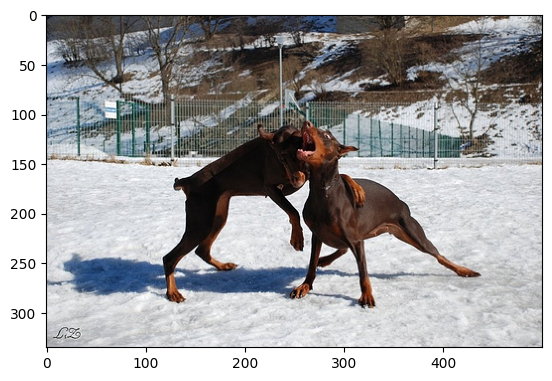

In [72]:
#z= z+1
pic = list(encoding_test.keys())[0]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()


In [75]:
print("Greedy:",greedySearch(image))

Greedy: brown dog is running on beach
